In [ ]:
# Importing essential libraries
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Importing specific modules from libraries
from torchvision import transforms
from os import path
from scipy.ndimage import rotate
from torch import nn
from sklearn.metrics import confusion_matrix

# Importing utility modules
import random
from torch.utils.data import Dataset, DataLoader, sampler
from copy import deepcopy
import nibabel as nib

In [ ]:
!wget --show-progress --verbose --tries=3 --no-check-certificate https://aramislab.paris.inria.fr/files/data/databases/DL4MI/OASIS-1-dataset_pt_new.tar.gz

--2024-06-03 03:17:59--  https://aramislab.paris.inria.fr/files/data/databases/DL4MI/OASIS-1-dataset_pt_new.tar.gz
Resolving aramislab.paris.inria.fr (aramislab.paris.inria.fr)... 128.93.101.235
Connecting to aramislab.paris.inria.fr (aramislab.paris.inria.fr)|128.93.101.235|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1387416064 (1.3G) [application/octet-stream]
Saving to: ‘OASIS-1-dataset_pt_new.tar.gz’

OASIS-1-dataset_pt_ 100%[===================>]   1.29G  27.9MB/s    in 47s     

2024-06-03 03:18:48 (28.0 MB/s) - ‘OASIS-1-dataset_pt_new.tar.gz’ saved [1387416064/1387416064]



In [ ]:
! tar xf OASIS-1-dataset_pt_new.tar.gz -C ./

   participant_id session_id alternative_id_1 sex  education_level  age_bl  \
0  sub-OASIS10001    ses-M00    OAS1_0001_MR1   F              2.0      74   
1  sub-OASIS10002    ses-M00    OAS1_0002_MR1   F              4.0      55   
2  sub-OASIS10003    ses-M00    OAS1_0003_MR1   F              4.0      73   
3  sub-OASIS10004    ses-M00    OAS1_0004_MR1   M              NaN      28   
4  sub-OASIS10005    ses-M00    OAS1_0005_MR1   M              NaN      18   

  diagnosis_bl laterality   MMS  cdr_global diagnosis  
0           CN          R  29.0         0.0        CN  
1           CN          R  29.0         0.0        CN  
2           AD          R  27.0         0.5        AD  
3           CN          R  30.0         NaN        CN  
4           CN          R  30.0         NaN        CN  


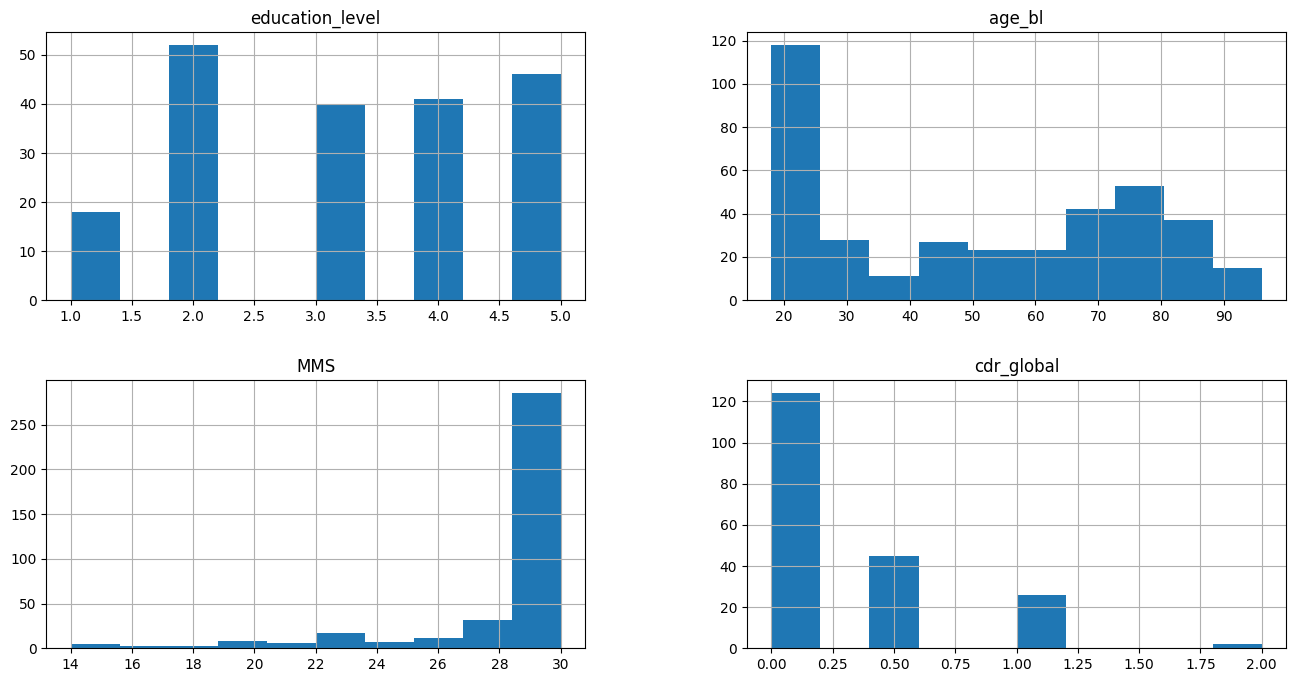

In [ ]:
# File path
file_path = 'OASIS-1_dataset/tsv_files/lab_1/OASIS_BIDS.tsv'

# Columns to load
columns_to_load = [
    'participant_id', 'session_id', 'alternative_id_1', 'sex',
    'education_level', 'age_bl', 'diagnosis_bl', 'laterality', 'MMS',
    'cdr_global', 'diagnosis']

# Read the CSV file using pandas of dataset
df_data = pd.read_csv(file_path, sep='\t', usecols=columns_to_load)
# Show first five items of the table
print(df_data.head())
# First visual inspection
_ = df_data.hist(figsize=(16, 8))

In [ ]:
class ds_MRI(Dataset):

    def __init__(self, image_directory, df_dataset, list_transforms=None):

        self.image_directory = image_directory
        self.list_transforms = list_transforms
        self.df_dataset = df_dataset
        self.diagnostic_code = {"AD": 1, "CN": 0}
        # Set the size attribute based on the shape of the first image in the dataset
        if len(self.df_dataset) > 0:
            self.size = self.__getitem__(0)['image'].shape
        else:
            raise ValueError("The dataset is empty, cannot determine image shape.")

    def __len__(self):
        return len(self.df_dataset)

    def __getitem__(self, idx):

        diag_stage = self.df_dataset.loc[idx, 'diagnosis']
        diagnosis_label = self.diagnostic_code[diag_stage]

        patient_id = self.df_dataset.loc[idx, 'participant_id']
        assignment_id = self.df_dataset.loc[idx, 'session_id']
        patient_file = (
            f'subjects/{patient_id}/{assignment_id}/'
            f'deeplearning_prepare_data/image_based/custom/'
            f'{patient_id}_{assignment_id}_T1w_segm-graymatter_space-Ixi549Space_modulated-off_probability.pt'
        )

        patient_image = torch.load(path.join(self.image_directory, patient_file))

        if self.list_transforms:
            patient_image = self.list_transforms(patient_image)

        sample = {'image': patient_image, 'label': diagnosis_label,
                  'participant_id': patient_id,
                  'session_id': assignment_id}
        return sample

    def train(self):
        self.list_transforms.train()

    def eval(self):
        self.list_transforms.eval()

In [ ]:
class CropRightHippoCampus(object):
    """Crops the right hippocampus of a MRI"""

    def __init__(self, rndm_move=0):
        self.rndm_move = rndm_move
        self.training_mode = True

    def __call__(self, img):
        if self.training_mode:
            x_dir = random.randint(-self.rndm_move, self.rndm_move)
            y_dir = random.randint(-self.rndm_move, self.rndm_move)
            z_dir = random.randint(-self.rndm_move, self.rndm_move)
        else:
            x_dir, y_dir, z_dir = 0, 0, 0

        # Calculate the indices for cropping
        x_start, x_end = 65 + x_dir, 95 + x_dir
        y_start, y_end = 50 + y_dir, 90 + y_dir
        z_start, z_end = 27 + z_dir, 57 + z_dir

        # Perform the crop and clone the resulting tensor
        return img[:, x_start:x_end, y_start:y_end, z_start:z_end].clone()

    def train(self):
        self.training_mode = True

    def eval(self):
        self.training_mode = False

In [ ]:
ds_train = pd.read_csv('OASIS-1_dataset/tsv_files/lab_1/train.tsv', sep='\t')
ds_test = pd.read_csv('OASIS-1_dataset/tsv_files/lab_1/validation.tsv', sep='\t')

class PadMaxPool3d(nn.Module):

    def __init__(self, kernel_size, stride, return_indices=False, return_pad=False):
            super().__init__()
            self.kernel_size = kernel_size
            self.stride = stride
            self.return_indices = return_indices
            self.return_pad = return_pad

            # Initialize the pooling and padding layers
            self.pool = nn.MaxPool3d(kernel_size=kernel_size, stride=stride, return_indices=return_indices)
            self.pad = nn.ConstantPad3d(padding=0, value=0)

    def forward(self, temp_map):
        coords = []
        for i in range(3):
            size = temp_map.size(i + 2)
            remainder = size % self.stride
            adjustment = self.stride - remainder
            coords.append(adjustment)

        coords = [0 if coord == self.stride else coord for coord in coords]

        self.pad.padding = (coords[2], 0, coords[1], 0, coords[0], 0)

        if self.return_indices:
            output, indices = self.pool(self.pad(temp_map))

            if self.return_pad:
                padding_info = (coords[2], 0, coords[1], 0, coords[0], 0)
                return output, indices, padding_info
            else:
                return output, indices

        else:
            output = self.pool(self.pad(temp_map))

            if self.return_pad:
                padding_info = (coords[2], 0, coords[1], 0, coords[0], 0)
                return output, padding_info
            else:
                return output

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CustomNetwork(nn.Module):
    def __init__(self):
        super(CustomNetwork, self).__init__()
        self.conv1 = nn.Conv3d(1, 8, 3, padding=1)
        self.bn1 = nn.BatchNorm3d(8)
        self.pool1 = PadMaxPool3d(2, 2)  # Assume PadMaxPool3d is defined elsewhere

        self.conv2 = nn.Conv3d(8, 16, 3, padding=1)
        self.bn2 = nn.BatchNorm3d(16)
        self.pool2 = PadMaxPool3d(2, 2)

        self.conv3 = nn.Conv3d(16, 32, 3, padding=1)
        self.bn3 = nn.BatchNorm3d(32)
        self.pool3 = PadMaxPool3d(2, 2)

        self.conv4 = nn.Conv3d(32, 64, 3, padding=1)
        self.bn4 = nn.BatchNorm3d(64)
        self.pool4 = PadMaxPool3d(2, 2)

        self.conv5 = nn.Conv3d(64, 128, 3, padding=1)
        self.bn5 = nn.BatchNorm3d(128)
        self.pool5 = PadMaxPool3d(2, 2)

        self.linear = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(256, 2)  # Assuming the size here based on the previous reduction
        )

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)

        x = F.leaky_relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)

        x = F.leaky_relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)

        x = F.leaky_relu(self.bn4(self.conv4(x)))
        x = self.pool4(x)

        x = F.leaky_relu(self.bn5(self.conv5(x)))
        x = self.pool5(x)

        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

In [ ]:
import torch.nn as nn

def train(model, train_loader, val_loader, criterion, optimizer, n_epochs):

    best_model = deepcopy(model)
    train_best_loss = np.inf
    losses = {'train': [], 'val': []}

    for epoch in range(n_epochs):
        model.train()
        total_loss = 0
        count = 0

        for data in train_loader:
            images, labels = data['image'].cuda(), data['label'].cuda()
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            count += 1

        train_loss = total_loss / count
        losses['train'].append(train_loss)

        # Validation loss
        model.eval()
        total_val_loss = 0
        val_count = 0
        with torch.no_grad():
            for data in val_loader:
                images, labels = data['image'].cuda(), data['label'].cuda()
                outputs = model(images)
                val_loss = criterion(outputs, labels)
                total_val_loss += val_loss.item()
                val_count += 1

        val_loss = total_val_loss / val_count
        losses['val'].append(val_loss)

        print(f"Epoch {epoch}: Train loss = {train_loss:.4f}, Val loss = {val_loss:.4f}")

        if val_loss < train_best_loss:
            best_model = deepcopy(model)
            train_best_loss = val_loss

    return best_model, losses

def plot_losses_per_lr(losses_dict):
    """
    Plots training and validation losses for each learning rate in separate graphs.

    Args:
        losses_dict: Dictionary where key is the learning rate and value is another dict
                     containing 'train' and 'val' losses lists.
    """
    for lr, losses in losses_dict.items():
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(losses['train'], label='Training Loss', color='blue')
        plt.title(f'Training Loss (LR={lr})')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(losses['val'], label='Validation Loss', color='red')
        plt.title(f'Validation Loss (LR={lr})')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

def test(model, data_loader, criterion):

    model.eval()
    data_loader.dataset.eval()
    columns = ["participant_id", "proba0", "proba1", "true_label", "predicted_label"]
    final_df = pd.DataFrame(columns=columns)
    total_loss = 0

    # Disable gradient computation for validation/testing
    with torch.no_grad():
        for i, data in enumerate(data_loader):
            # Move images and labels to GPU
            images = data['image'].cuda()
            labels = data['label'].cuda()
            # Forward pass: compute predicted outputs
            outputs = model(images)
            # Compute the loss
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            # Compute probabilities using Softmax
            probs = nn.Softmax(dim=1)(outputs)
            # Get the predicted class with the highest probability
            _, predicted = torch.max(outputs.data, 1)
            # Prepare data for the results DataFrame
            rows = [
                [
                    data['participant_id'][idx],
                    probs[idx, 0].item(),
                    probs[idx, 1].item(),
                    labels[idx].item(),
                    predicted[idx].item()
                ]
                for idx in range(len(data['participant_id']))
            ]

            # Create a DataFrame from the rows and concatenate to the results DataFrame
            batch_df = pd.DataFrame(rows, columns=columns)
            final_df = pd.concat([final_df, batch_df], ignore_index=True)

    # Convert the true_labels and predicted_labels to integers

    true_labels = final_df['true_label'].to_numpy(dtype=int)
    predicted_labels = final_df['predicted_label'].to_numpy(dtype=int)

    # Print unique values and types for debugging
    print("True labels unique values:", np.unique(true_labels), "Type:", true_labels.dtype)
    print("Predicted labels unique values:", np.unique(predicted_labels), "Type:", predicted_labels.dtype)

    # Compute metrics for true and predicted labels
    final_metrics = compute_metrics(true_labels, predicted_labels)

    # Reset the index of the results DataFrame
    final_df.reset_index(drop=True, inplace=True)

    # Calculate mean loss and add it to the results metrics
    mean_loss = total_loss / len(data_loader.dataset)
    final_metrics['mean_loss'] = mean_loss

    return final_df, final_metrics

def compute_metrics(ground_truth, prediction):
    """Computes the accuracy, sensitivity, specificity, balanced accuracy, and confusion matrix"""
    # Ensure that ground_truth and prediction are numpy arrays
    ground_truth = np.array(ground_truth)
    prediction = np.array(prediction)

    # Compute confusion matrix
    cm = confusion_matrix(ground_truth, prediction)

    true_positives = np.sum((prediction == 1) & (ground_truth == 1))
    true_negatives = np.sum((prediction == 0) & (ground_truth == 0))
    false_positives = np.sum((prediction == 1) & (ground_truth == 0))
    false_negatives = np.sum((prediction == 0) & (ground_truth == 1))

    metrics_dict = dict()
    metrics_dict['accuracy'] = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)

    # Sensitivity
    if true_positives + false_negatives != 0:
        metrics_dict['sensitivity'] = true_positives / (true_positives + false_negatives)
    else:
        metrics_dict['sensitivity'] = 0.0

    # Specificity
    if false_positives + true_negatives != 0:
        metrics_dict['specificity'] = true_negatives / (false_positives + true_negatives)
    else:
        metrics_dict['specificity'] = 0.0

    metrics_dict['balanced_accuracy'] = (metrics_dict['sensitivity'] + metrics_dict['specificity']) / 2
    metrics_dict['confusion_matrix'] = cm

    # Print the confusion matrix
    print("Confusion Matrix:\n", cm)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return metrics_dict

def plot_separate_losses(loss_history):
    """
    Function to plot training and validation losses on separate graphs for the best performing model.

    Args:
        loss_history: (dict) containing lists of training and validation losses
    """
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(loss_history['train'], label='Training Loss', color='blue')
    plt.title('Training Loss for Best Model')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(loss_history['val'], label='Validation Loss', color='red')
    plt.title('Validation Loss for Best Model')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def display_confusion_matrix(conf_matrix):
    """
    Displays the confusion matrix using seaborn heatmap.

    Args:
        conf_matrix: (numpy array) the confusion matrix
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix for Best Model')
    plt.show()


Epoch 0: Train loss = 2.6659, Val loss = 13.0933
Epoch 1: Train loss = 1.8626, Val loss = 11.3632
Epoch 2: Train loss = 1.8047, Val loss = 15.0086
Epoch 3: Train loss = 1.5562, Val loss = 10.4780
Epoch 4: Train loss = 1.5768, Val loss = 11.0452
Epoch 5: Train loss = 1.2937, Val loss = 10.8064
Epoch 6: Train loss = 1.5978, Val loss = 15.9799
Epoch 7: Train loss = 1.5379, Val loss = 10.4494
Epoch 8: Train loss = 1.3907, Val loss = 9.1613
Epoch 9: Train loss = 1.9579, Val loss = 12.1488
Epoch 10: Train loss = 1.1876, Val loss = 16.4100
Epoch 11: Train loss = 1.1247, Val loss = 11.0747
Epoch 12: Train loss = 1.4985, Val loss = 9.3221
Epoch 13: Train loss = 1.2309, Val loss = 10.3953
Epoch 14: Train loss = 1.1252, Val loss = 10.1160
Epoch 15: Train loss = 1.3597, Val loss = 12.6507
Epoch 16: Train loss = 1.0084, Val loss = 13.1332
Epoch 17: Train loss = 1.4782, Val loss = 11.3640
Epoch 18: Train loss = 1.1275, Val loss = 11.2146
Epoch 19: Train loss = 1.2050, Val loss = 12.1238
Epoch 20: Tr

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


True labels unique values: [0 1] Type: int64
Predicted labels unique values: [0 1] Type: int64
Confusion Matrix:
 [[60  2]
 [ 7  8]]


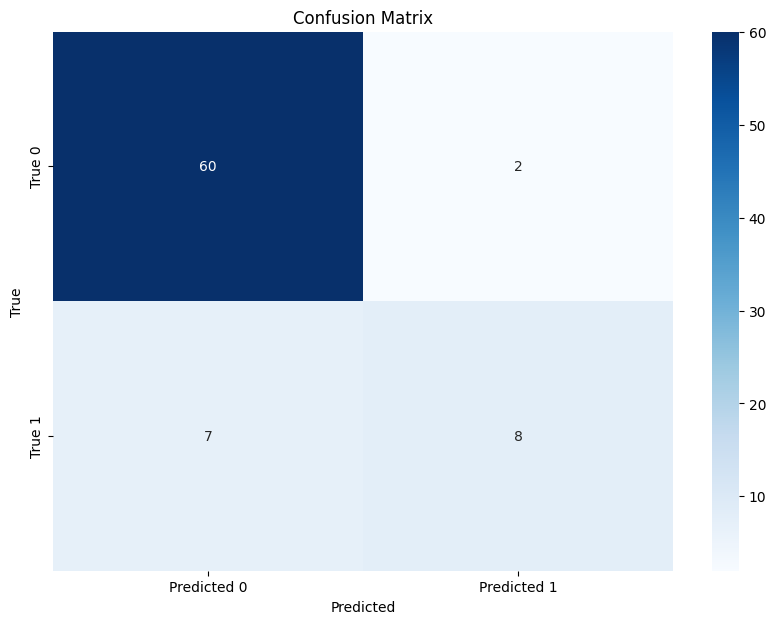

Learning Rate: 0.001 - Validation Accuracy: 0.8831168831168831


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 0: Train loss = 2.2388, Val loss = 7.7521
Epoch 1: Train loss = 1.2209, Val loss = 7.3943
Epoch 2: Train loss = 0.8476, Val loss = 7.2508
Epoch 3: Train loss = 0.9679, Val loss = 7.8275
Epoch 4: Train loss = 0.8837, Val loss = 9.1149
Epoch 5: Train loss = 0.8280, Val loss = 12.9045
Epoch 6: Train loss = 0.8026, Val loss = 7.2862
Epoch 7: Train loss = 0.7713, Val loss = 7.4863
Epoch 8: Train loss = 0.7416, Val loss = 8.2856
Epoch 9: Train loss = 0.6516, Val loss = 7.3628
Epoch 10: Train loss = 0.9926, Val loss = 10.9933
Epoch 11: Train loss = 0.5144, Val loss = 8.8852
Epoch 12: Train loss = 0.4937, Val loss = 10.4995
Epoch 13: Train loss = 0.7961, Val loss = 8.7285
Epoch 14: Train loss = 0.5183, Val loss = 8.2491
Epoch 15: Train loss = 0.2626, Val loss = 9.6026
Epoch 16: Train loss = 0.3986, Val loss = 10.7267
Epoch 17: Train loss = 0.1754, Val loss = 8.8690
Epoch 18: Train loss = 0.1297, Val loss = 8.6310
Epoch 19: Train loss = 0.1099, Val loss = 8.6286
Epoch 20: Train loss = 0.0

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


True labels unique values: [0 1] Type: int64
Predicted labels unique values: [0 1] Type: int64
Confusion Matrix:
 [[58  4]
 [ 4 11]]


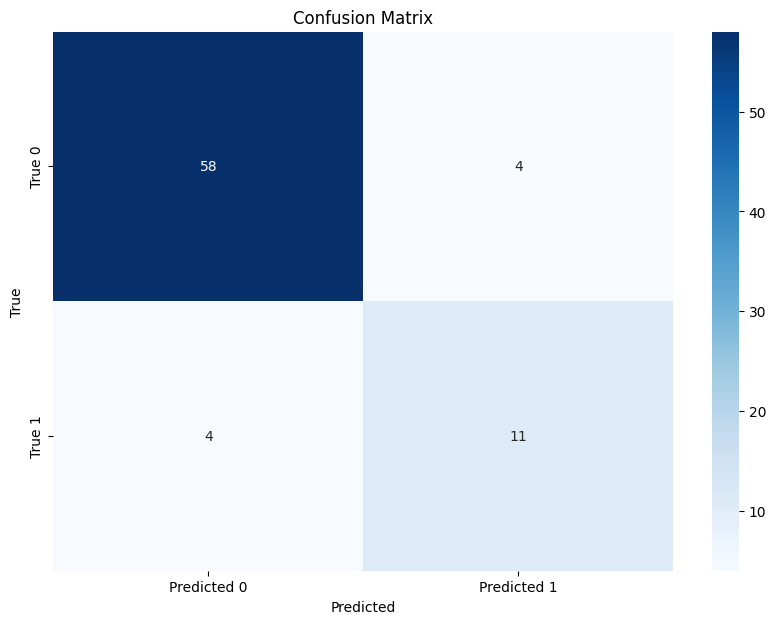

Learning Rate: 0.0005 - Validation Accuracy: 0.8961038961038961


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 0: Train loss = 2.1223, Val loss = 8.8092
Epoch 1: Train loss = 1.4695, Val loss = 7.7873
Epoch 2: Train loss = 1.2392, Val loss = 8.6041
Epoch 3: Train loss = 1.1142, Val loss = 8.5964
Epoch 4: Train loss = 1.1309, Val loss = 7.3613
Epoch 5: Train loss = 1.0258, Val loss = 7.7234
Epoch 6: Train loss = 0.8762, Val loss = 7.4234
Epoch 7: Train loss = 0.8591, Val loss = 7.4343
Epoch 8: Train loss = 0.8719, Val loss = 7.3180
Epoch 9: Train loss = 0.8276, Val loss = 7.8145
Epoch 10: Train loss = 0.7063, Val loss = 9.2314
Epoch 11: Train loss = 0.6180, Val loss = 7.8485
Epoch 12: Train loss = 0.7039, Val loss = 7.9500
Epoch 13: Train loss = 0.6466, Val loss = 7.9666
Epoch 14: Train loss = 0.5786, Val loss = 9.6523
Epoch 15: Train loss = 0.5894, Val loss = 7.2698
Epoch 16: Train loss = 0.5477, Val loss = 7.0891
Epoch 17: Train loss = 0.4256, Val loss = 9.8586
Epoch 18: Train loss = 0.5521, Val loss = 9.2535
Epoch 19: Train loss = 0.3783, Val loss = 7.8664
Epoch 20: Train loss = 0.3567,

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


True labels unique values: [0 1] Type: int64
Predicted labels unique values: [0 1] Type: int64
Confusion Matrix:
 [[57  5]
 [ 6  9]]


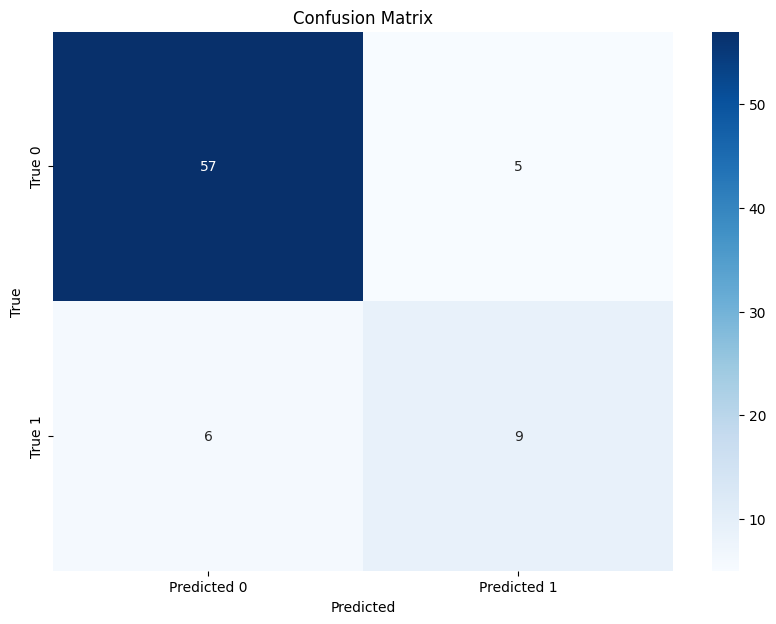

Learning Rate: 0.0001 - Validation Accuracy: 0.8571428571428571


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 0: Train loss = 2.1979, Val loss = 10.0966
Epoch 1: Train loss = 1.8354, Val loss = 8.6953
Epoch 2: Train loss = 1.4077, Val loss = 7.9884
Epoch 3: Train loss = 1.2691, Val loss = 7.1931
Epoch 4: Train loss = 1.2903, Val loss = 7.0093
Epoch 5: Train loss = 0.9875, Val loss = 7.9036
Epoch 6: Train loss = 0.8910, Val loss = 7.0856
Epoch 7: Train loss = 1.0625, Val loss = 6.6788
Epoch 8: Train loss = 0.8446, Val loss = 6.5800
Epoch 9: Train loss = 0.9862, Val loss = 6.8071
Epoch 10: Train loss = 1.1124, Val loss = 6.9465
Epoch 11: Train loss = 0.8661, Val loss = 6.7448
Epoch 12: Train loss = 0.7797, Val loss = 6.8529
Epoch 13: Train loss = 0.8393, Val loss = 6.5080
Epoch 14: Train loss = 0.7547, Val loss = 6.7994
Epoch 15: Train loss = 0.8122, Val loss = 6.4990
Epoch 16: Train loss = 0.6020, Val loss = 6.4522
Epoch 17: Train loss = 0.6136, Val loss = 6.5066
Epoch 18: Train loss = 0.6637, Val loss = 6.7820
Epoch 19: Train loss = 0.5948, Val loss = 6.4146
Epoch 20: Train loss = 0.5766

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


True labels unique values: [0 1] Type: int64
Predicted labels unique values: [0 1] Type: int64
Confusion Matrix:
 [[58  4]
 [ 6  9]]


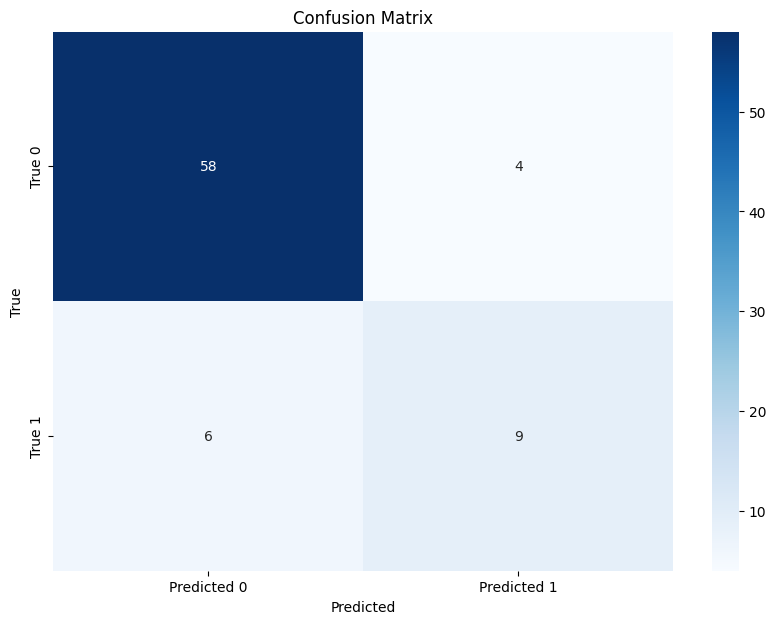

Learning Rate: 5e-05 - Validation Accuracy: 0.8701298701298701


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 0: Train loss = 2.4612, Val loss = 12.1538
Epoch 1: Train loss = 2.1938, Val loss = 11.5664
Epoch 2: Train loss = 1.9132, Val loss = 10.9185
Epoch 3: Train loss = 1.9340, Val loss = 10.4772
Epoch 4: Train loss = 1.7671, Val loss = 10.0487
Epoch 5: Train loss = 1.6135, Val loss = 9.5777
Epoch 6: Train loss = 1.6437, Val loss = 9.5620
Epoch 7: Train loss = 1.7599, Val loss = 9.1732
Epoch 8: Train loss = 1.4662, Val loss = 8.7722
Epoch 9: Train loss = 1.4684, Val loss = 8.6426
Epoch 10: Train loss = 1.5240, Val loss = 8.4959
Epoch 11: Train loss = 1.4652, Val loss = 8.2658
Epoch 12: Train loss = 1.3955, Val loss = 8.0671
Epoch 13: Train loss = 1.4597, Val loss = 8.0235
Epoch 14: Train loss = 1.3186, Val loss = 7.8469
Epoch 15: Train loss = 1.3581, Val loss = 7.9053
Epoch 16: Train loss = 1.1760, Val loss = 7.6863
Epoch 17: Train loss = 1.2247, Val loss = 7.7001
Epoch 18: Train loss = 1.2077, Val loss = 7.7118
Epoch 19: Train loss = 1.1507, Val loss = 7.6328
Epoch 20: Train loss = 1.

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


True labels unique values: [0 1] Type: int64
Predicted labels unique values: [0 1] Type: int64
Confusion Matrix:
 [[59  3]
 [ 7  8]]


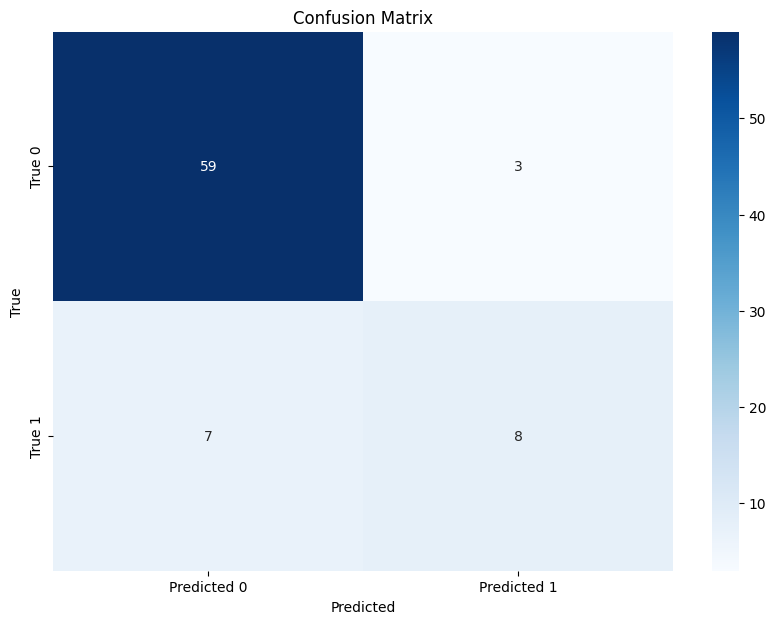

Learning Rate: 1e-05 - Validation Accuracy: 0.8701298701298701


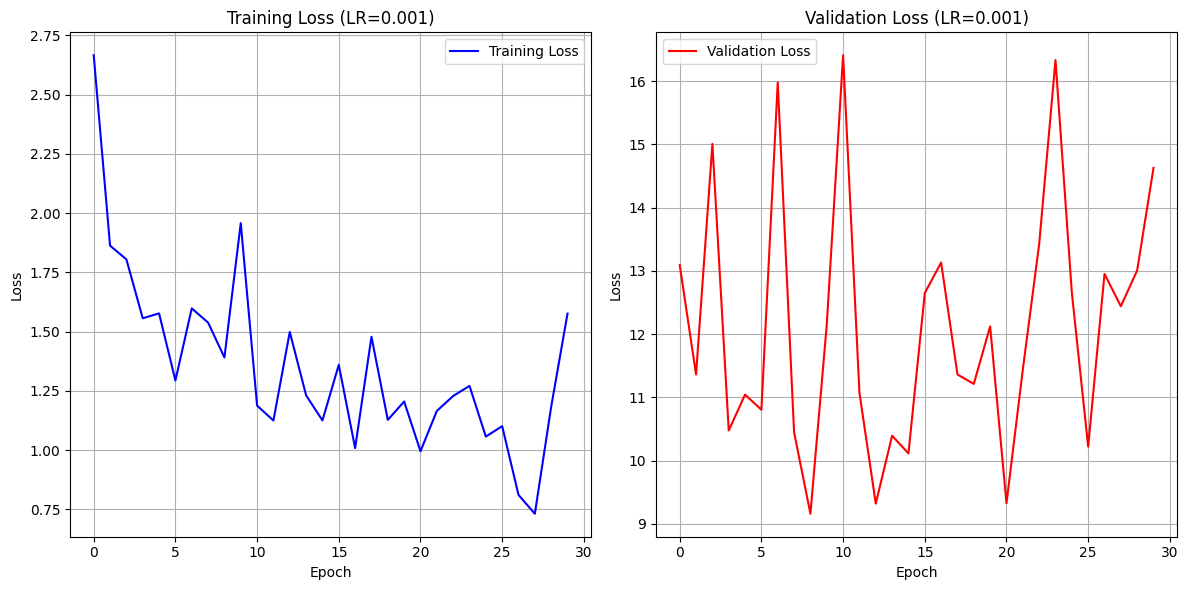

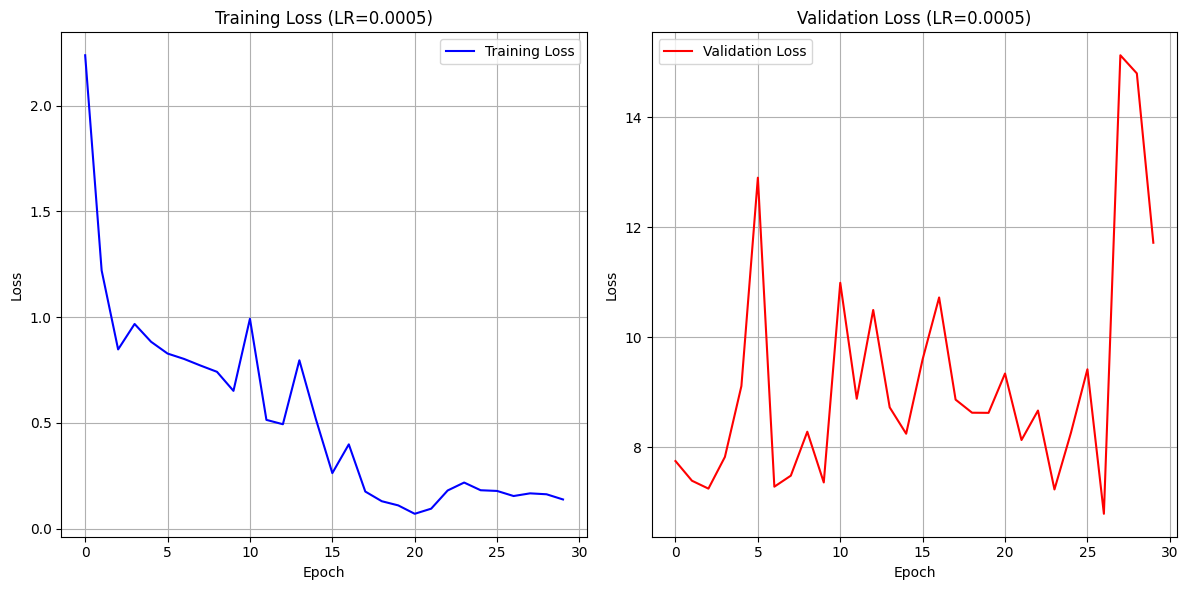

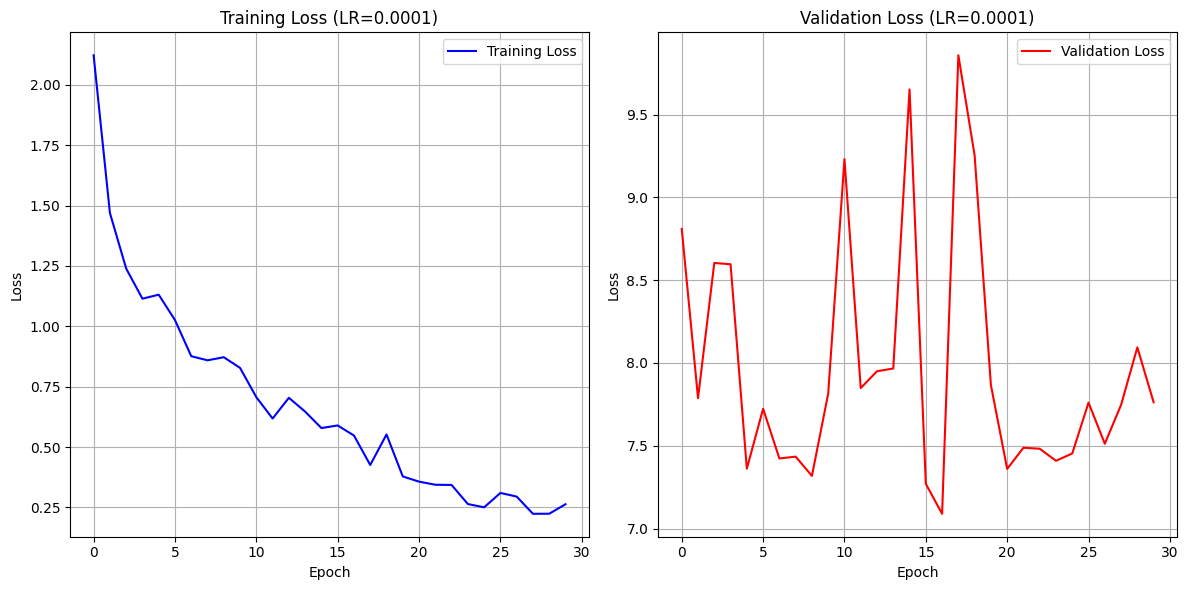

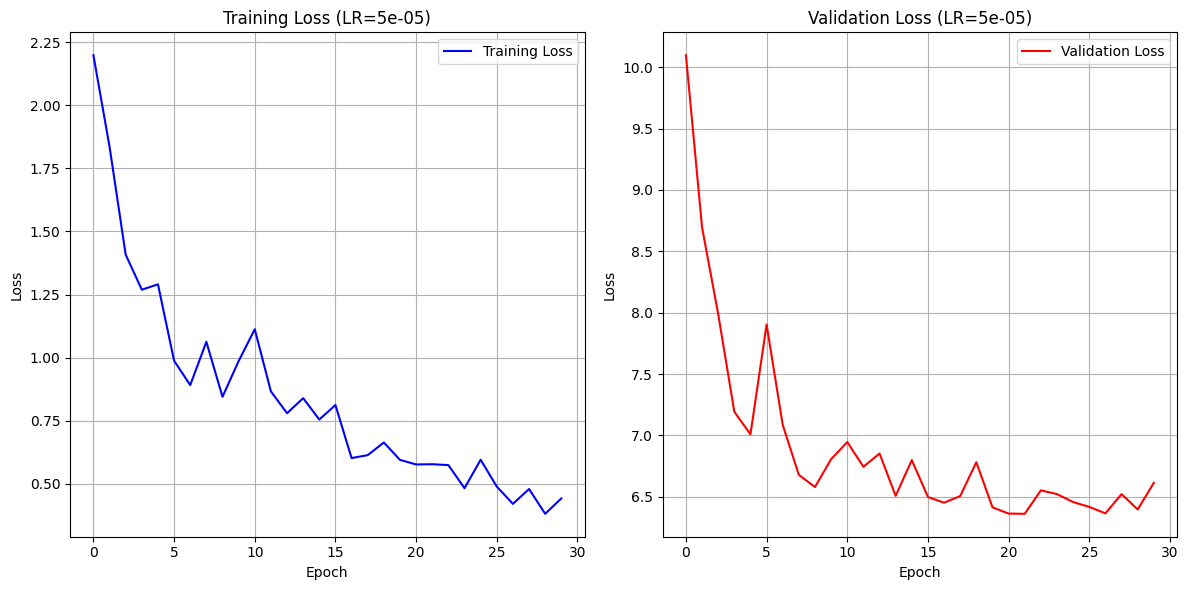

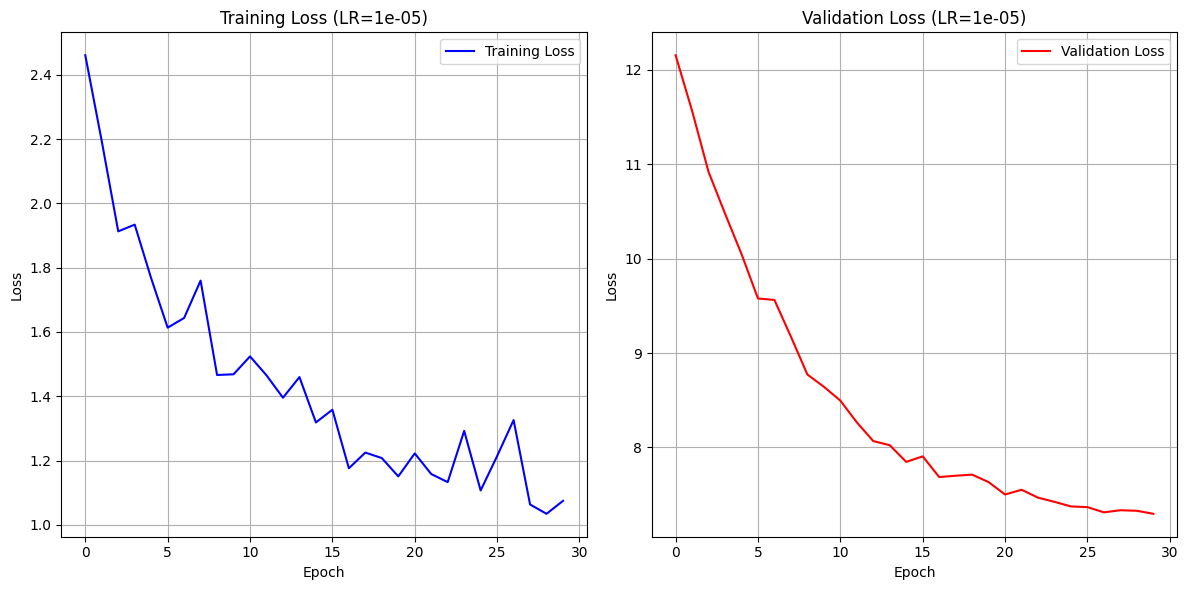

In [ ]:
import itertools
# Path setup, dataset, and transforms

image_directory = path.join('OASIS-1_dataset', 'CAPS')
list_transforms = CropRightHippoCampus(2)

train_RightHippoCampus = ds_MRI(image_directory, ds_train, list_transforms=list_transforms)
test_RightHippoCampus = ds_MRI(image_directory, ds_test, list_transforms=list_transforms)

# Hyperparameter setup
learning_rates = [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]
n_epochs = 30
batch_size = 4
loss_histories = {}

# Training and validation setup
for lr in learning_rates:
    model_RightHippoCampus = CustomNetwork().cuda()
    optimizer = torch.optim.Adam(model_RightHippoCampus.parameters(), lr=lr)
    trainloader_RightHC = DataLoader(train_RightHippoCampus, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
    testloader_RightHC = DataLoader(test_RightHippoCampus, batch_size=32, shuffle=False, num_workers=8, pin_memory=True)

    # Train and evaluate the model
    best_model, losses = train(model_RightHippoCampus, trainloader_RightHC, testloader_RightHC, nn.CrossEntropyLoss(reduction='sum').cuda(), optimizer, n_epochs)
    loss_histories[lr] = losses

    # Evaluate the model
    valid_resultsLeftHC_df, valid_metricsLeftHC  = test(best_model, testloader_RightHC, nn.CrossEntropyLoss(reduction='sum').cuda())
    print(f"Learning Rate: {lr} - Validation Accuracy: {valid_metricsLeftHC['accuracy']}")

# Plot losses for each learning rate
plot_losses_per_lr(loss_histories)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 0: Train loss = 2.9911, Val loss = 11.7456
Epoch 1: Train loss = 2.3452, Val loss = 11.9867
Epoch 2: Train loss = 2.2534, Val loss = 12.0499
Epoch 3: Train loss = 2.2762, Val loss = 11.0802
Epoch 4: Train loss = 2.1945, Val loss = 10.5963
Epoch 5: Train loss = 2.0986, Val loss = 10.7089
Epoch 6: Train loss = 2.0420, Val loss = 10.9815
Epoch 7: Train loss = 2.0848, Val loss = 10.9212
Epoch 8: Train loss = 2.0089, Val loss = 10.7739
Epoch 9: Train loss = 1.9731, Val loss = 10.4338
Epoch 10: Train loss = 1.8195, Val loss = 10.5225
Epoch 11: Train loss = 1.8101, Val loss = 9.8995
Epoch 12: Train loss = 1.7758, Val loss = 10.3098
Epoch 13: Train loss = 1.8932, Val loss = 9.4252
Epoch 14: Train loss = 1.8744, Val loss = 9.9148
Epoch 15: Train loss = 1.9297, Val loss = 9.8380
Epoch 16: Train loss = 1.8128, Val loss = 9.7331
Epoch 17: Train loss = 1.7537, Val loss = 9.4980
Epoch 18: Train loss = 1.7316, Val loss = 9.6770
Epoch 19: Train loss = 1.9719, Val loss = 9.5421
Epoch 20: Train lo

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


True labels unique values: [0 1] Type: int64
Predicted labels unique values: [0 1] Type: int64
Confusion Matrix:
 [[62  0]
 [10  5]]


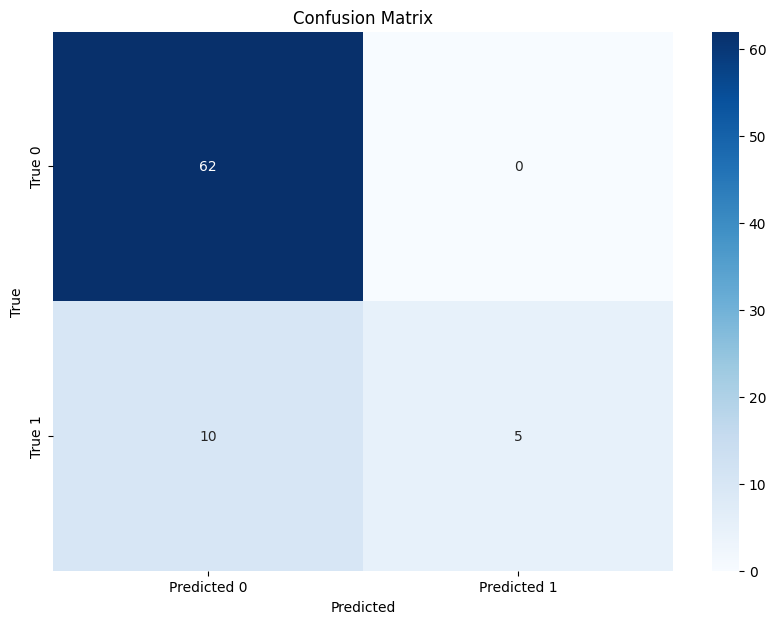

Learning Rate: 5e-06 - Validation Accuracy: 0.8701298701298701


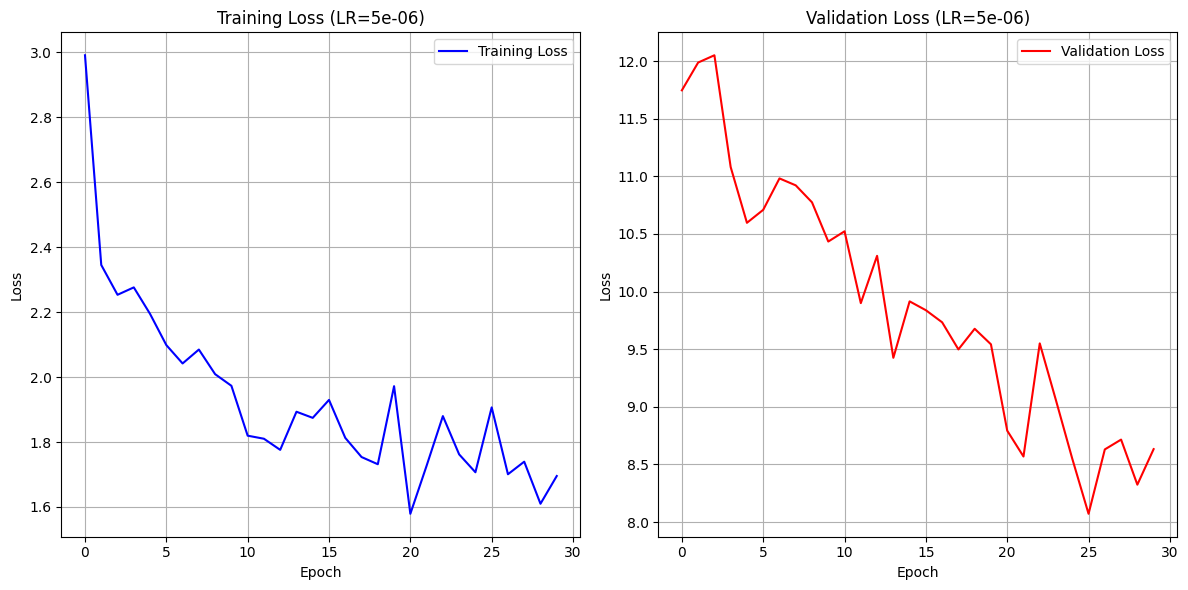

In [ ]:
import itertools

image_directory = path.join('OASIS-1_dataset', 'CAPS')
list_transforms = CropRightHippoCampus(2)

# Prepare datasets
train_RightHippoCampus = ds_MRI(image_directory, ds_train, list_transforms=list_transforms)
test_RightHippoCampus = ds_MRI(image_directory, ds_test, list_transforms=list_transforms)


# Hyperparameter setup
learning_rates = [5e-6]
n_epochs = 30
batch_size = 4
loss_histories = {}

# Training and validation setup
for lr in learning_rates:
    model_RightHippoCampus = CustomNetwork().cuda()
    optimizer = torch.optim.Adam(model_RightHippoCampus.parameters(), lr=lr)
    trainloader_RightHC = DataLoader(train_RightHippoCampus, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
    testloader_RightHC = DataLoader(test_RightHippoCampus, batch_size=32, shuffle=False, num_workers=8, pin_memory=True)

    # Train and evaluate the model
    best_model, losses = train(model_RightHippoCampus, trainloader_RightHC, testloader_RightHC, nn.CrossEntropyLoss(reduction='sum').cuda(), optimizer, n_epochs)
    loss_histories[lr] = losses

    # Evaluate the model
    valid_resultsLeftHC_df, valid_metricsLeftHC  = test(best_model, testloader_RightHC, nn.CrossEntropyLoss(reduction='sum').cuda())
    print(f"Learning Rate: {lr} - Validation Accuracy: {valid_metricsLeftHC['accuracy']}")

# Plot losses for each learning rate
plot_losses_per_lr(loss_histories)